In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
path = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 11'

In [ ]:
pip install onnxruntime-gpu insightface opencv-python

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Đã tải và khởi tạo mô hình InsightFace thành công!
Tìm thấy 1 khuôn mặt trong ảnh.

--- Thông 

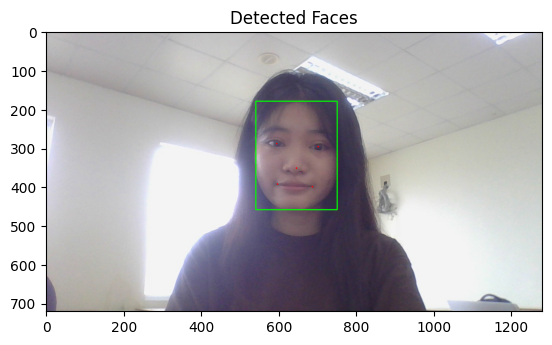

In [23]:
import cv2
import insightface
from insightface.app import FaceAnalysis
import numpy as np
import matplotlib.pyplot as plt


app = FaceAnalysis(allowed_modules=['detection', 'recognition'])

app.prepare(ctx_id=0, det_size=(640, 640))

print("Đã tải và khởi tạo mô hình InsightFace thành công!")


image_path = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 11/output_images/An/frame_0.jpg' # THAY ĐỔI ĐƯỜNG DẪN NÀY

# Đọc ảnh bằng OpenCV
img = cv2.imread(image_path)


faces = app.get(img)

print(f"Tìm thấy {len(faces)} khuôn mặt trong ảnh.")

for i, face in enumerate(faces):
    print(f"\n--- Thông tin Khuôn mặt {i+1} ---")

    bbox = face.bbox.astype(int)
    print(f"Bounding Box: {bbox}")

    kps = face.kps.astype(int)
    print(f"Keypoints (mắt, mũi, khóe miệng...): \n{kps}")

    embedding = face.embedding
    print(f"Shape của Vector đặc trưng (Embedding): {embedding.shape}")

    x1, y1, x2, y2 = bbox
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2) # Vẽ bounding box (màu xanh lá)

    for kp in kps:
          cv2.circle(img, tuple(kp), 2, (0, 0, 255), -1) # Vẽ keypoints (màu đỏ)

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # Chuyển đổi sang RGB
plt.title("Detected Faces")
plt.show()


In [24]:
import os
import cv2
import insightface
from insightface.app import FaceAnalysis
import numpy as np
import matplotlib.pyplot as plt

def detect_faces_in_folders(root_folder):
    """
    Detects faces in all images within subfolders of the root folder.

    Args:
        root_folder: The path to the root folder containing image subfolders.
    """
    app = FaceAnalysis(allowed_modules=['detection', 'recognition'])
    app.prepare(ctx_id=0, det_size=(640, 640))
    print("Đã tải và khởi tạo mô hình InsightFace thành công!")

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(folder_path, filename)
                    img = cv2.imread(image_path)

                    if img is not None:
                        faces = app.get(img)
                        print(f"Đang xử lý ảnh: {image_path}")
                        print(f"Tìm thấy {len(faces)} khuôn mặt trong ảnh.")

                        for i, face in enumerate(faces):
                            bbox = face.bbox.astype(int)
                            kps = face.kps.astype(int)
                            embedding = face.embedding

                            x1, y1, x2, y2 = bbox
                            cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
                            for kp in kps:
                                cv2.circle(img, tuple(kp), 2, (0, 0, 255), -1)

                        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
                        plt.title(f"Detected Faces in {filename}")
                        plt.show()
                    else:
                        print(f"Không thể đọc ảnh: {image_path}")

# Example usage:
root_folder = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 11/output_images'
detect_faces_in_folders(root_folder)

Output hidden; open in https://colab.research.google.com to view.

In [27]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 65.1 MB/s eta 0:00:00


In [57]:
import os
import cv2
import insightface
from insightface.app import FaceAnalysis
import numpy as np
import matplotlib.pyplot as plt
import faiss

def detect_faces_and_store_embeddings(root_folder, db_path="/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 11/face_embeddings.bin"):
    """
    Detects faces in images, extracts embeddings, and stores them in a Faiss database.

    Args:
        root_folder: The path to the root folder containing image subfolders.
        db_path: The path to store the Faiss database file.
    """
    app = FaceAnalysis(allowed_modules=['detection', 'recognition'])
    app.prepare(ctx_id=0, det_size=(640, 640))
    print("Đã tải và khởi tạo mô hình InsightFace thành công!")

    embeddings = []  # Store embeddings
    metadata = []  # Store corresponding folder names (person names)

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(folder_path, filename)
                    img = cv2.imread(image_path)

                    if img is not None:
                        faces = app.get(img)
                        print(f"Đang xử lý ảnh: {image_path}")
                        print(f"Tìm thấy {len(faces)} khuôn mặt trong ảnh.")

                        for face in faces:
                            embeddings.append(face.embedding)
                            metadata.append(folder_name)  # Store folder name as metadata

    # Create Faiss index
    dimension = embeddings[0].shape[0]  # Dimension of embeddings
    index = faiss.IndexFlatIP(dimension)  # Use L2 distance

    # Convert embeddings to NumPy array
    embeddings_np = np.array(embeddings).astype('float32')

    # Add embeddings to Faiss index
    index.add(embeddings_np)

    # Store Faiss index and metadata
    faiss.write_index(index, db_path)
    with open(db_path + ".metadata", "w") as f:
        for name in metadata:
            f.write(name + "\n")

    print(f"Đã lưu trữ {len(embeddings)} embeddings và metadata vào {db_path}")

# Example usage:
root_folder = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 11/output_images'
detect_faces_and_store_embeddings(root_folder)

Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Đã tải và khởi tạo mô hình InsightFace thành công!
Đang xử lý ảnh: /content/drive/MyDrive/CV n

In [77]:
import os
import cv2
import insightface
from insightface.app import FaceAnalysis
import numpy as np
import matplotlib.pyplot as plt
import faiss

def detect_faces_and_store_embeddings(root_folder, db_path="/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 11/face_embeddings.bin"):
    """
    Detects faces in images, extracts embeddings, and stores them in a Faiss database.

    Args:
        root_folder: The path to the root folder containing image subfolders.
        db_path: The path to store the Faiss database file.
    """
    app = FaceAnalysis(allowed_modules=['detection', 'recognition'])
    app.prepare(ctx_id=0, det_size=(640, 640))
    print("Đã tải và khởi tạo mô hình InsightFace thành công!")

    embeddings = []  # Store embeddings
    metadata = []  # Store corresponding folder names (person names)
    # Create Faiss index
    index = faiss.IndexFlatIP(512)  # Use L2 distance

    for folder_name in os.listdir(root_folder):
        folder_path = os.path.join(root_folder, folder_name)
        if os.path.isdir(folder_path):
            for filename in os.listdir(folder_path):
                if filename.endswith(('.jpg', '.jpeg', '.png')):
                    image_path = os.path.join(folder_path, filename)
                    img = cv2.imread(image_path)

                    if img is not None:
                        faces = app.get(img)
                        print(f"Đang xử lý ảnh: {image_path}")
                        print(f"Tìm thấy {len(faces)} khuôn mặt trong ảnh.")

                        for face in faces:
                            index.add(face.embedding.reshape(1, -1).astype('float32'))
                            metadata.append(folder_name)  # Store folder name as metadata


    # Store Faiss index and metadata
    faiss.write_index(index, db_path)
    with open(db_path + ".metadata", "w") as f:
        for name in metadata:
            f.write(name + "\n")

    print(f"Đã lưu trữ {len(embeddings)} embeddings và metadata vào {db_path}")

# Example usage:
root_folder = '/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 11/output_images'
detect_faces_and_store_embeddings(root_folder)

/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Đã tải và khởi tạo mô hình InsightFace thành công!
Đang xử lý ảnh: /content/drive/MyDrive/CV n

In [83]:
import os
import cv2
import insightface
from insightface.app import FaceAnalysis
import numpy as np
import matplotlib.pyplot as plt
import faiss

def load_face_db(db_path="face_embeddings.bin"):
    """Loads the Faiss database and metadata."""
    # index = faiss.IndexFlatIP(512)
    index = faiss.read_index(db_path)
    with open(db_path + ".metadata", "r") as f:
        metadata = [line.strip() for line in f]
    return index, metadata

def recognize_face(image_path, index, metadata, app):
    """Recognizes a face in an image using the loaded database."""
    img = cv2.imread(image_path)
    faces = app.get(img)

    if faces:
        embedding = faces[0].embedding  # Assuming only one face in the test image
        embedding = embedding.reshape(1, -1).astype('float32')
        print((embedding.shape))
        # Search for nearest neighbors in the database
        D, I = index.search(embedding, k=1)  # k=1 for the closest match

        # Get the predicted person's name
        predicted_person = metadata[I[0][0]]
        print(f"Khuôn mặt được nhận dạng là: {predicted_person}")
        print(D)
    else:
        print("Không tìm thấy khuôn mặt trong ảnh.")

# Example usage:
db_path = "/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 11/face_embeddings.bin"
index, metadata = load_face_db(db_path)

# Initialize FaceAnalysis (you might need to do this only once)
app = FaceAnalysis(allowed_modules=['detection', 'recognition'])
app.prepare(ctx_id=0, det_size=(640, 640))

test_image_path = "/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 11/output_images/Chung/frame_1.jpg"
recognize_face(test_image_path, index, metadata, app)

<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7b85515a2f40> >


/usr/local/lib/python3.11/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:121: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
model ignore: /root/.insightface/models/buffalo_l/genderage.onnx genderage
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
(1, 512)
Khuôn mặt được nhận dạng là: Chung
[[581.5476]]


In [94]:
index, metadata = load_face_db(db_path)
print(index)
embedding = index.reconstruct(0)
print(np.linalg.norm(embedding))

<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7b85542c2430> >
<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7b85542c2430> >
23.888588


In [105]:
index, metadata = load_face_db(db_path)
print(index)

image_path = "/content/drive/MyDrive/CV nâng cao/Bài tập trên lớp/Tuần 11/output_images/An/frame_1.jpg"
img = cv2.imread(image_path)
faces = app.get(img)

if faces:
    embedding = faces[0].embedding  # Assuming only one face in the test image
    embedding = embedding.reshape(1, -1).astype('float32')
    print((embedding.shape))
    # Search for nearest neighbors in the database
    D, I = index.search(embedding, k=1)
    inner_product = D[0][0]  # Lấy inner product từ kết quả D
    embedding_norm = np.linalg.norm(embedding)  # Tính norm của embedding đầu vào
    # **Fix: Create an empty array and pass it to reconstruct**
    # reconstructed_embedding = np.empty(embedding.shape[1], dtype=np.float32)
    reconstructed_embedding = index.reconstruct(int(I[0][0]))
    reconstructed_embedding_norm = np.linalg.norm(reconstructed_embedding)
    cosine_similarity = inner_product / (embedding_norm * reconstructed_embedding_norm)  # Tính cosine similarity
    print("Cosine Similarity:", cosine_similarity)
    # Get the predicted person's name
    predicted_person = metadata[I[0][0]]
    print(f"Khuôn mặt được nhận dạng là: {predicted_person}")
    print(D)

<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7b8551686700> >
<faiss.swigfaiss_avx2.IndexFlatIP; proxy of <Swig Object of type 'faiss::IndexFlatIP *' at 0x7b8551686700> >
(1, 512)
Cosine Similarity: 1.0
Khuôn mặt được nhận dạng là: An
[[480.94006]]
